In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import os


%matplotlib inline

(720, 1280, 3)


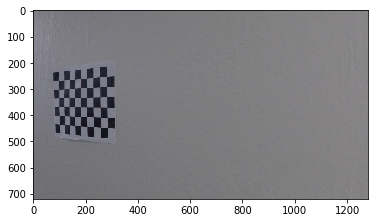

In [2]:
img=mpimg.imread ('camera_cal/calibration11.jpg')
image_shape=img.shape
print(image_shape)
plt.imshow(img)

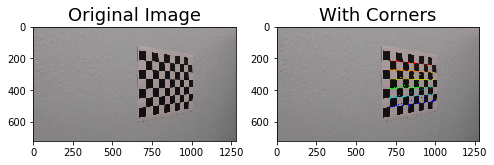

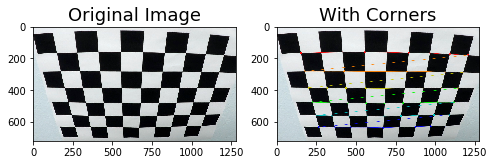

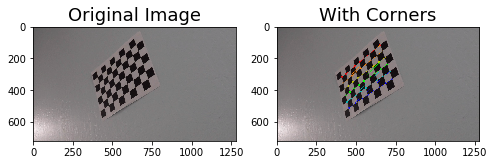

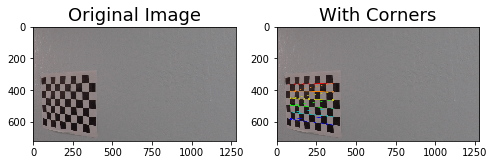

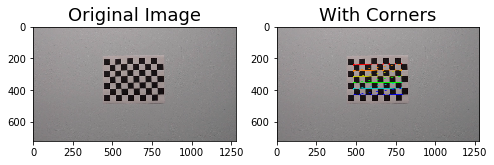

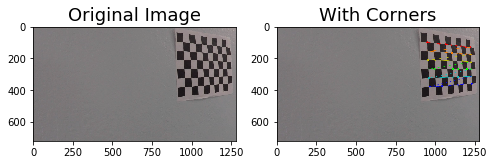

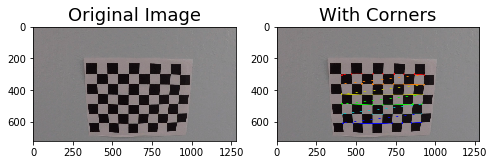

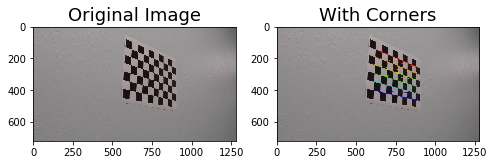

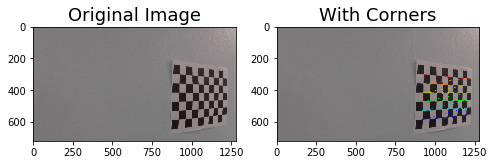

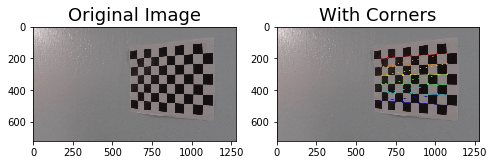

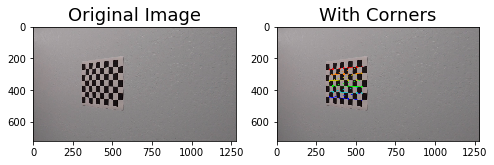

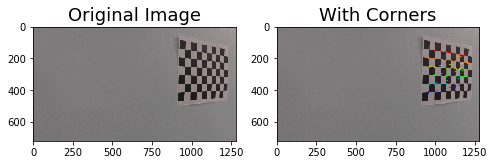

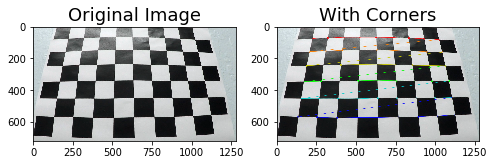

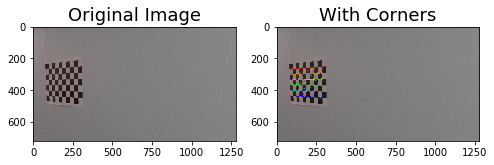

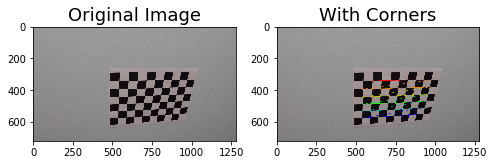

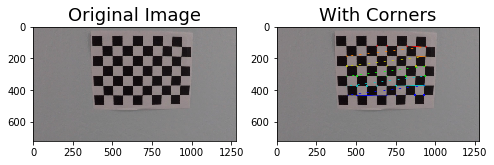

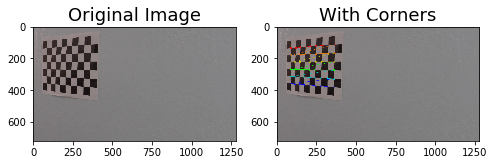

In [3]:
nx=9 #9 corners in X direction, except edges
ny=6 #6 corners in Y direction

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Cameras distort images since they project actual 3d images to 2d images
objpoints=[] #3d image in real world
imgpoints=[] #2d image viewed by camera

fnames=glob.glob('camera_cal/calibration*.jpg')
for fname in fnames:
    img=mpimg.imread(fname)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners=cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)
        
        


In [4]:

# Define a function to Remove distortion from images
def undistort(image,show=True):
    
    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:  
        return undist

In [5]:
def save(dir, fname, img):
    fname = ''.join([dir,'undistorted_',fname])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(fname,img)

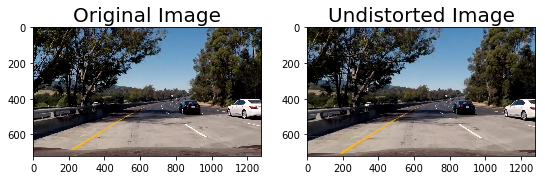

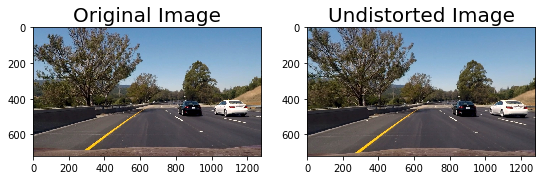

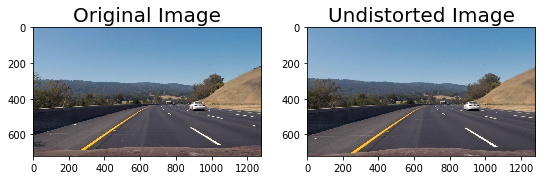

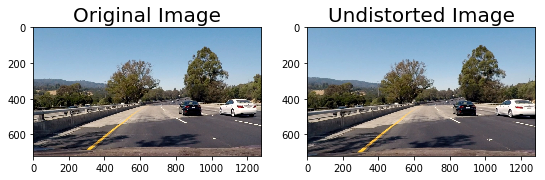

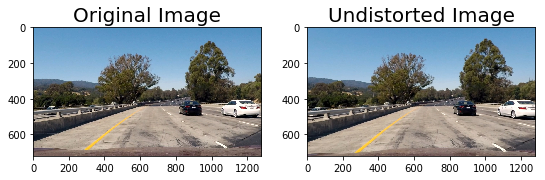

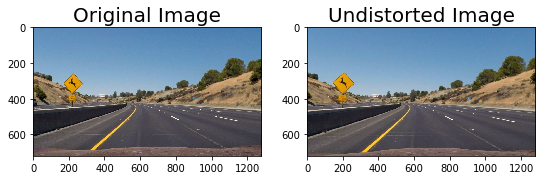

In [6]:
# Undistort the test_images
images = glob.glob('test_images/test*.jpg')
i=0
for image in images:
    i=i+1
    undist=undistort(image,show=False)
    img = cv2.imread(image) 
    #saving to a folder
    path='./output_images/undistorted_'+ str(i) +'.jpg'
    cv2.imwrite(path,undist)
    #cv2.imwrite(os.path.join(path , 'undist_',image), newundist)
    #save('output_images/', image, undist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=20)

In [7]:
# Perform Perspective transform of undistorted images
# This gives a bird's eye view of images 
# Images are focused on lane lines
# Lane lines appear parallel to each other
# Makes it easier to fit polynomials to lane lines and determine curvature


In [8]:
def perspective_transform (img,display=True):
    undist=undistort(img,show=False) #First undistort image
    img_size = (undist.shape[1], undist.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1280, 720],[0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)  # matrix for perspective transform
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size) #apply the tranform matrix to get bird's eye view of lane lines
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M, Minv

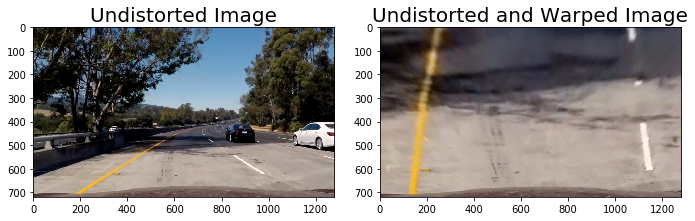

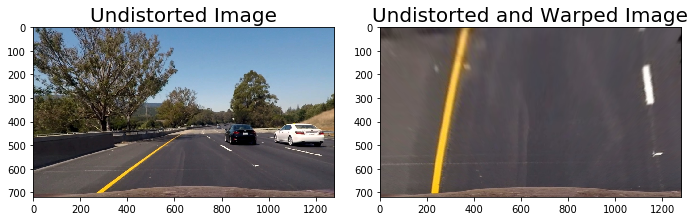

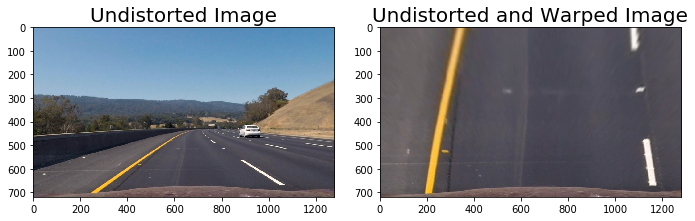

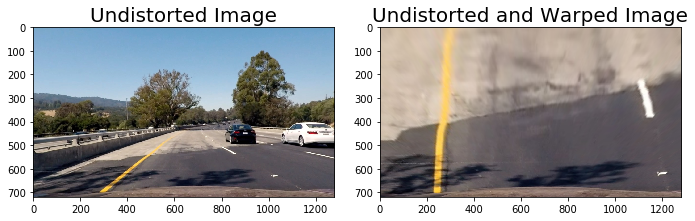

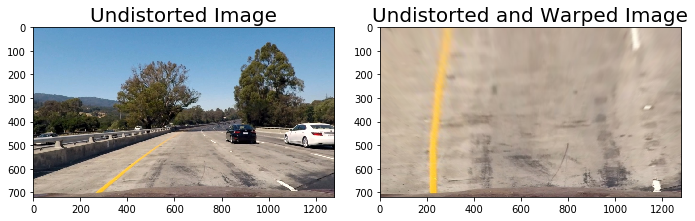

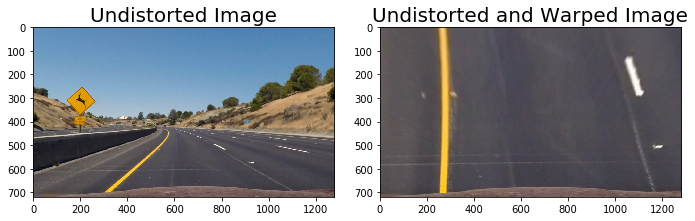

In [9]:
i=0
for image in glob.glob('test_images/test*.jpg'):
    #warped,M=perspective_transform(image,display=False)
    perspective_transform(image)
    #i=i+1
    #path='./output_images/warped_'+ str(i) +'.jpg'
    #cv2.imwrite(path,warped)

In [10]:
# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(image, show=True):
    img, M, Minv = perspective_transform (image, display = False)
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2] # S channel gets both white and yellow but is distracted by shadows
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0] #L channel great at picking white lane lines but ignores yellow lines
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2] #B channel picks yellow lines perfectly but ignores white lines
    
    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel>=l_thresh_min) & (l_channel<=l_thresh_max)] = 1
    

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary==1) | (b_binary==1)] = 1
    
    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('b binary threshold', fontsize=16)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.set_title('l binary threshold', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('Combined color thresholds', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary, M, Minv

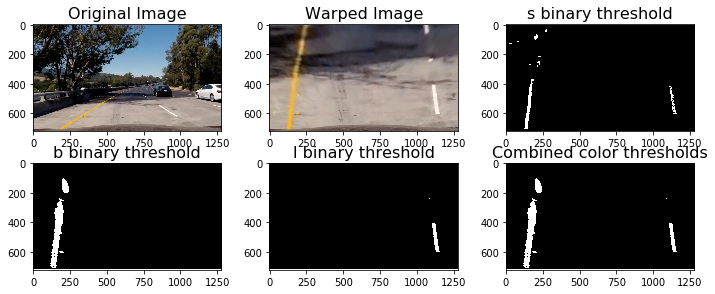

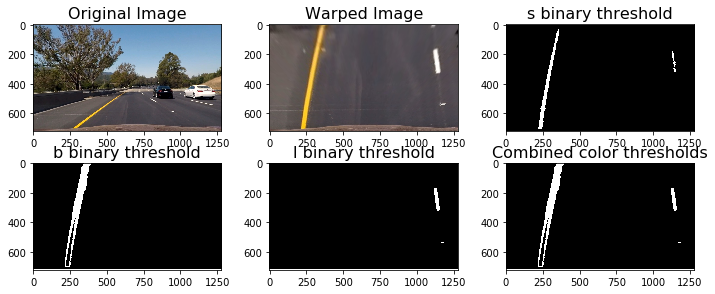

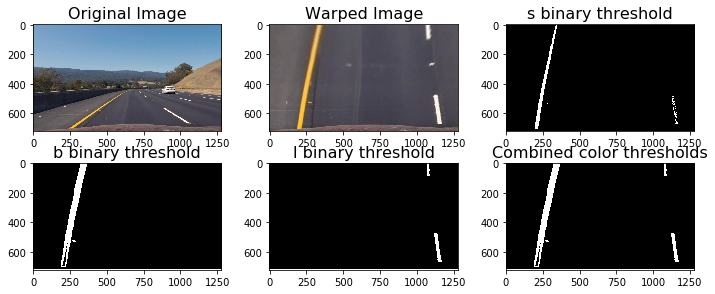

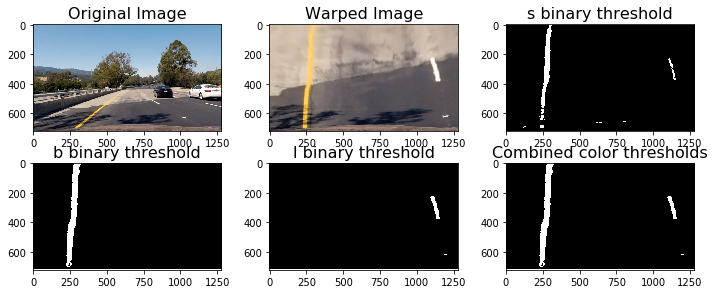

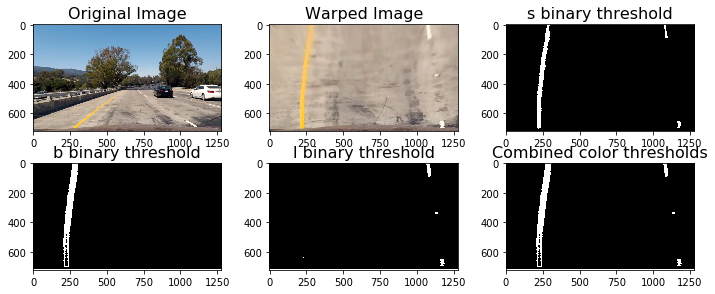

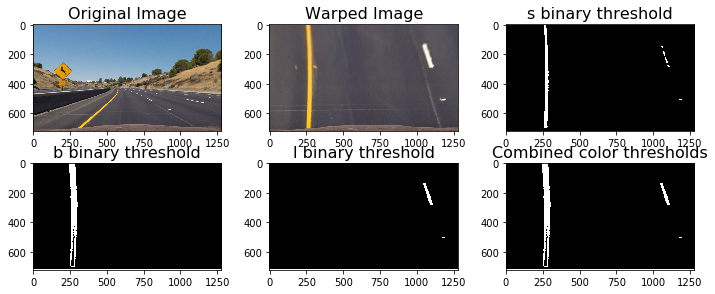

In [11]:
i=0
for image in glob.glob('test_images/test*.jpg'):
    apply_thresholds(image)
    combined_binary,M,Minv=apply_thresholds(image,show=False)
    i=i+1
    path='./output_images/combinedbinary_'+ str(i) +'.jpg'
    cv2.imwrite(path,combined_binary)

In [12]:
#Now lane lines are detected by taking histogram of the lower half and seearching for non-zero pixels
def find_line(image,viewlane=True):
    binary_warped, M, Minv=apply_thresholds(image,show=False)
    histogram=np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
    
    
    #print(histogram.shape)
    out_img=np.dstack((binary_warped,binary_warped,binary_warped))*255 #create an image to draw on
    
    #Find the peak of left and right lanes as starting point
    midpoint=np.int(histogram.shape[0]//2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    #print(leftx,rightx)
    #plt.plot(histogram)
    
    #Find x and y poisitions of all non-zero pixels in image
    nonzeros=binary_warped.nonzero()
    nonzeros_y=np.array(nonzeros[0])
    nonzeros_x=np.array(nonzeros[1])
    
   #Current positions to be updated for each window
    leftx_current=leftx_base
    rightx_current=rightx_base
    
   # HYPERPARAMETERS    
    nwindows = 10                   # Choose the number of sliding windows
    margin = 100                    # Set the width of the windows +/- margin
    minpixels = 50          # Set minimum number of pixels found to recenter window
    num_rows=binary_warped.shape[0] 
    window_height=np.int(num_rows/nwindows) #Calculate height of each sliding window
    
    #Empty lists to receive left and right lane pixel indices
    left_coordinates=[] 
    right_coordinates=[]
    
    #Step through the windows one by one
    for window in range (nwindows):
        #Identify window boundaries 
        y_min=binary_warped.shape[0]-window_height*(window+1)
        y_max=binary_warped.shape[0]-window_height*(window) #first value of window=0, bottom of the image
        
        leftx_min=leftx_current-margin
        leftx_max=leftx_current+margin
        
        rightx_min=rightx_current-margin
        rightx_max=rightx_current+margin
        
        # Draw the window on the visualization image
        cv2.rectangle(out_img, (leftx_min, y_min), (leftx_max, y_max), [0,0,255],2) #image, start_point, end point, color, thickness
        cv2.rectangle(out_img, (rightx_min, y_min), (rightx_max, y_max), [255,0,0],2) 
        
        #Identify nonzero pixels in X and Y within the window
        #Left lane
        good_left_inds = ((nonzeros_y >= y_min) & (nonzeros_y < y_max) & 
        (nonzeros_x >= leftx_min) &  (nonzeros_x < leftx_max)).nonzero()[0]
        left_coordinates.append(good_left_inds)
        
        #Right lane
        good_right_inds = ((nonzeros_y >= y_min) & (nonzeros_y < y_max) & 
        (nonzeros_x >= rightx_min) &  (nonzeros_x < rightx_max)).nonzero()[0]
        right_coordinates.append(good_right_inds)
        
        # Slide the window in X direction to recenter on mean of non-zero X pixels
        # Left lane sliding window
        if(len(left_coordinates)>minpixels):
            leftx_current=np.int(np.mean(nonzeros_x[left_coordinates]))
            
        #Right lane sliding window
        if(len(right_coordinates)>minpixels):
            rightx_current=np.int(np.mean(nonzeros_x[right_coordinates]))
          
        #Concatenate the arrays of indices
    #print(left_coordinates)
    left_lane_inds = np.concatenate(left_coordinates)
    right_lane_inds = np.concatenate(right_coordinates)
    
        #out_img[nonzeros_y[left_coordinates], nonzeros_x[left_coordinates]] = [255,0,0]
        #out_img[nonzeros_y[right_coordinates], nonzeros_x[right_coordinates]] = [0,0,255]

        # Extract left and right line pixel positions
    leftx = nonzeros_x[left_lane_inds]
    lefty = nonzeros_y[left_lane_inds] 
    rightx = nonzeros_x[right_lane_inds]
    righty = nonzeros_y[right_lane_inds] 
    
        # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
        
        # Generate x and y values for plotting

    ploty = np.linspace(0, num_rows-1, num_rows )
    leftx_predict = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx_predict = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
    out_img[nonzeros_y[left_lane_inds], nonzeros_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeros_y[right_lane_inds], nonzeros_x[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([leftx_predict-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([leftx_predict+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([rightx_predict-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([rightx_predict+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
    if viewlane==True:
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure(figsize=(20,10))
        plt.imshow(result)
        plt.plot(leftx_predict, ploty, color='yellow')
        plt.plot(rightx_predict, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    else:
        return leftx_predict,rightx_predict, M, Minv
        #return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)


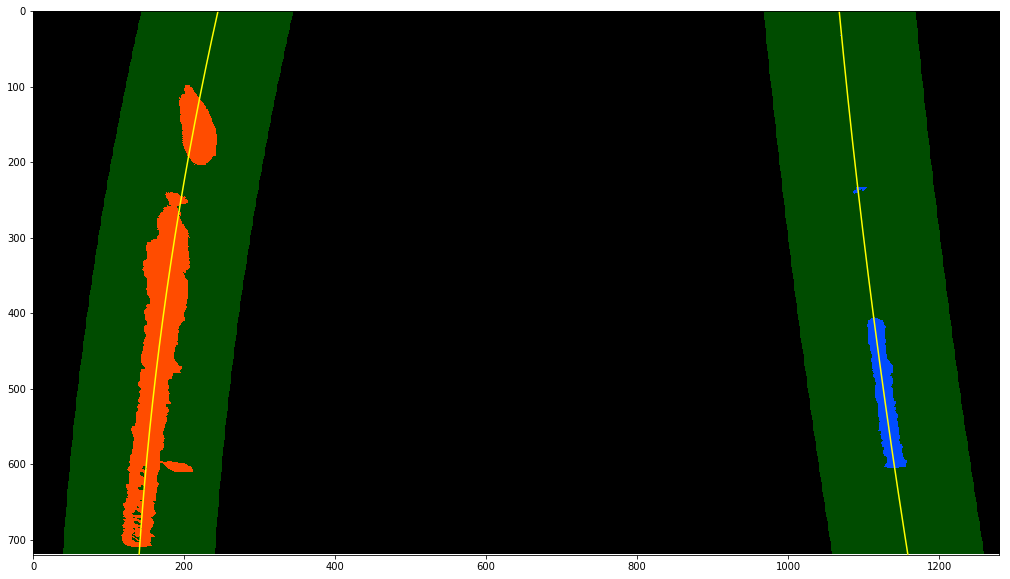

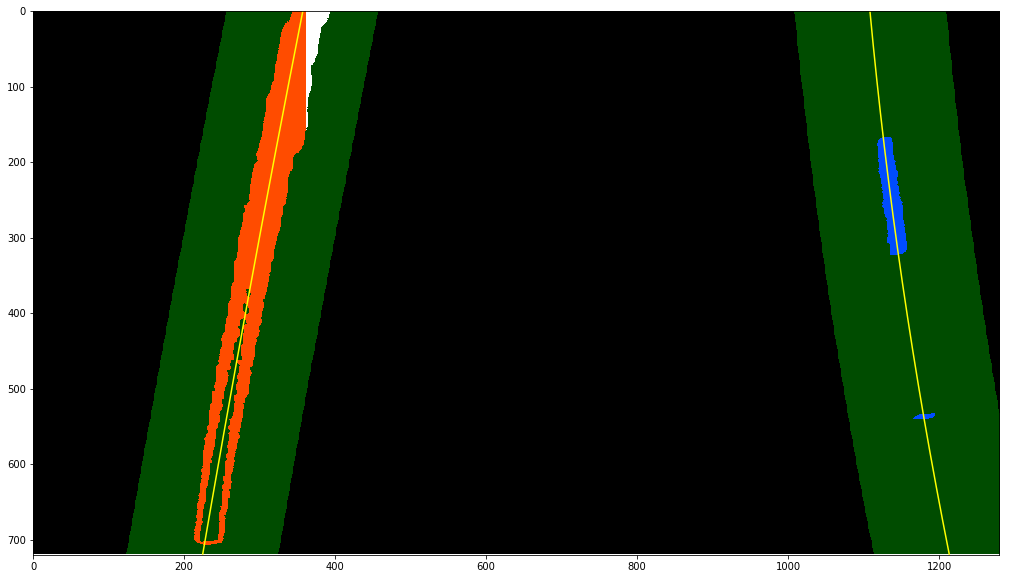

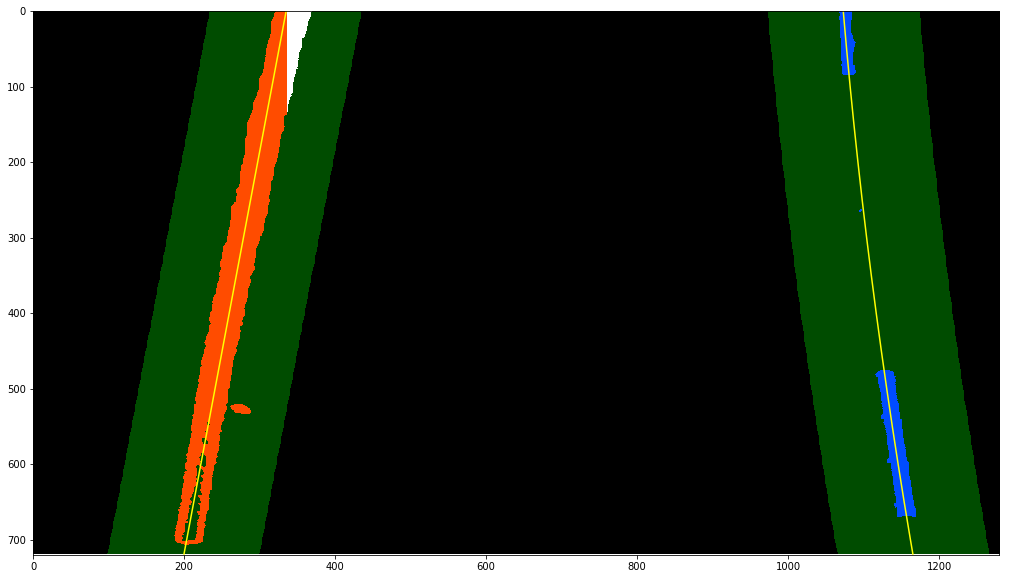

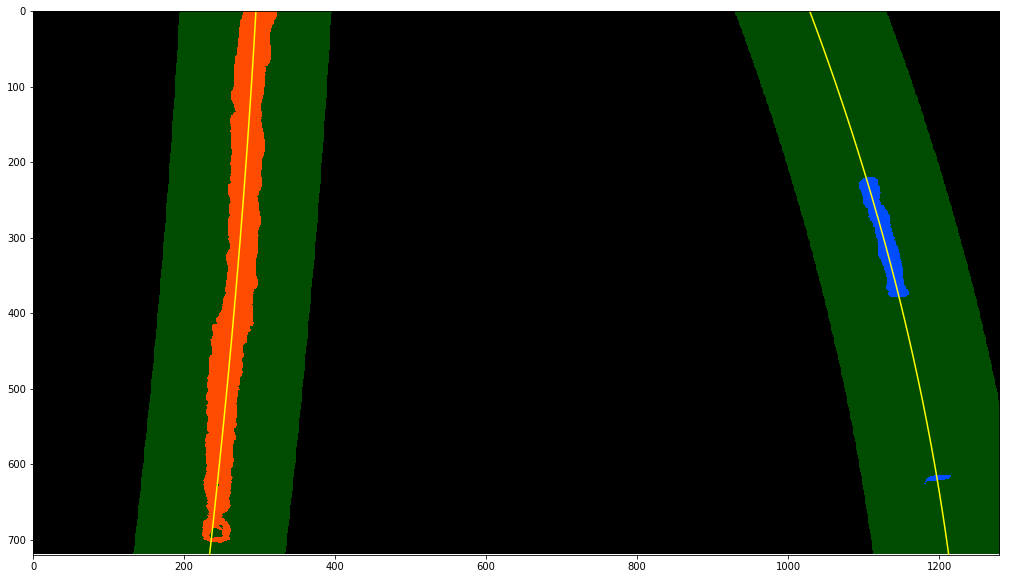

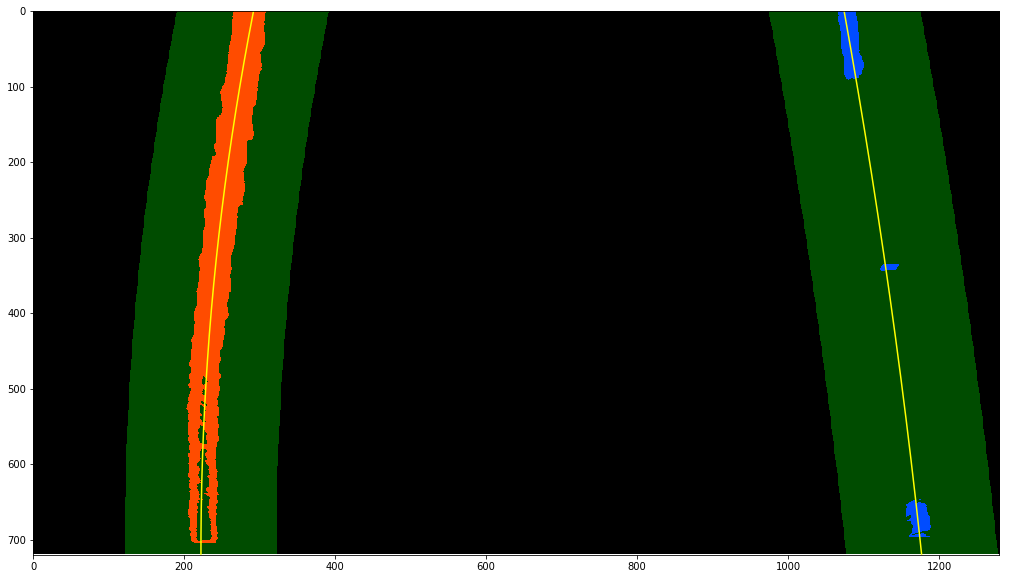

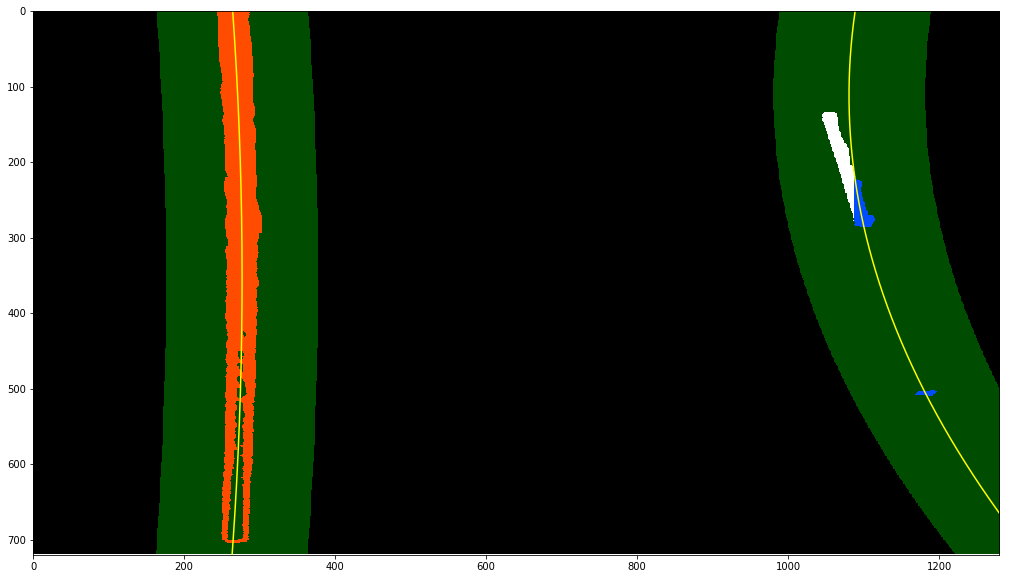

In [13]:
for image in glob.glob('test_images/test*.jpg'):
    find_line(image,viewlane=True)

In [14]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    num_rows=720
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

for image in glob.glob('test_images/test*.jpg'):
    leftx_predict,rightx_predict,M,Minv=find_line(image,viewlane=False)    
    left_curve_rad = measure_radius_of_curvature(leftx_predict)
    right_curve_rad = measure_radius_of_curvature(rightx_predict)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    print(curvature_string)

# compute the offset from the center
    img_size = [720,1280]
    
    lane_center = (rightx_predict[719] - leftx_predict[719])/2 + leftx_predict[719]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[1]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    print(offset_string)

Radius of curvature: 2622.11 m
Center offset: 0.05 m
Radius of curvature: 5820.89 m
Center offset: 0.42 m
Radius of curvature: 76069.77 m
Center offset: 0.23 m
Radius of curvature: 2600.23 m
Center offset: 0.44 m
Radius of curvature: 2194.94 m
Center offset: 0.31 m
Radius of curvature: 957.93 m
Center offset: 0.80 m


In [15]:
def final_image(image):
    
        combined_binary, M, Minv = apply_thresholds(image, show=False)
        num_rows=720
        y_points = np.linspace(0, num_rows-1, num_rows)
    
        leftx_predict,rightx_predict, M, Minv=find_line(image,viewlane=False)    
        left_curve_rad = measure_radius_of_curvature(leftx_predict)
        right_curve_rad = measure_radius_of_curvature(rightx_predict)
        average_curve_rad = (left_curve_rad + right_curve_rad)/2
        curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
        print(curvature_string)

# compute the offset from the center
        img_size = [720,1280]
        lane_center = (rightx_predict[719] - leftx_predict[719])/2 + leftx_predict[719]
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        center_offset_pixels = abs(img_size[1]/2 - lane_center)
        center_offset_mtrs = xm_per_pix*center_offset_pixels
    

    
    #img_size = (img.shape[1], img.shape[0])
#        src = np.float32([[490, 482],[810, 482],
#                      [1250, 720],[40, 720]])
#        dst = np.float32([[0, 0], [1280, 0], 
#                     [1250, 720],[40, 720]])
#        Minv = cv2.getPerspectiveTransform(dst, src)
    
        warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.flipud(np.transpose(np.vstack([leftx_predict, y_points])))])
        pts_right = np.array([np.transpose(np.vstack([rightx_predict, y_points]))])
        pts = np.hstack((pts_left, pts_right))
        cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
        result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
        
            # Draw info
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (255, 255, 255)
        fontScale = 1
        #cv2.putText(imgFile, "{:.2f}".format(distance1), (10,500), font, 4,(255,255,255), 2, cv2.LINE_AA)
        cv2.putText(result, "Average curvature is {:.2f} ".format(average_curve_rad), (50, 50), font, fontScale, fontColor, 2, cv2.LINE_AA)        
        cv2.putText(result, "Vehicle is {:.2f} of center ".format(center_offset_mtrs), (50, 190), font, fontScale, fontColor, 2, cv2.LINE_AA)
        return result,leftx_predict,rightx_predict,left_curve_rad,right_curve_rad, center_offset_mtrs 
            
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        fig.tight_layout()
        ax1.imshow(cv2.cvtColor((perspective_transform(image, display=False)[0]), cv2.COLOR_BGR2RGB))
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.plot(leftx_predict, y_points, color='green', linewidth=3)
        ax1.plot(rightx_predict, y_points, color='green', linewidth=3)
        ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
        ax1.invert_yaxis() # to visualize as we do the images
        ax2.imshow(result)
        ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
        if lane_center < 640:
            ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center_offset_mtrs),
                 style='italic', color='white', fontsize=10)
        else:
            ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center_offset_mtrs),
                 style='italic', color='white', fontsize=10)
        ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((average_curve_rad))),
             style='italic', color='white', fontsize=10)
    #path=str('./output_images/finalimages_'+ str(i) +'.jpg')    
            #fig.savefig('./output_images/finalimages.png')   # save the figure to file
    #plt.close(f)
      
        

In [ ]:
i=0
for image in glob.glob('test_images/test*.jpg'):
    i=i+1
    result,_,_,_,_,_=final_image(image)
    path='./output_images/final_image_'+ str(i) +'.jpg'
    cv2.imwrite(path,cv2.cvtColor(result, cv2.COLOR_BGR2RGB))


Radius of curvature: 2622.11 m
Radius of curvature: 5820.89 m
Radius of curvature: 76069.77 m
Radius of curvature: 2600.23 m
